In [203]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import cv2
import numpy as np
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [177]:
import pathlib

data_dir = pathlib.Path('ECG')

### Data preprocessing

In [201]:
def preprocessing(image):
    image = cv2.GaussianBlur(image, (3,3),0)  # bluring for noise reduction
    image = cv2.threshold(image,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] # thresholding
    image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,15,2) # binary adaptive thresholding
    image = cv2.bitwise_not(image) # inverting
    kernel = np.ones((3,3),np.uint8) # morphological kernel
    image = cv2.dilate(image, kernel, iterations=1) # dilate
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel) # closing
    
    return image

In [204]:
for i in os.listdir('ECG//COVID'):
    img = cv2.imread(f'ECG//COVID//{i}',cv2.IMREAD_GRAYSCALE)
    cv2.imwrite(f'ECG//COVID//{i}',preprocessing(img))

In [205]:
for i in os.listdir('ECG//NOCOVID'):
    img = cv2.imread(f'ECG//NOCOVID//{i}',cv2.IMREAD_GRAYSCALE)
    cv2.imwrite(f'ECG//NOCOVID//{i}',preprocessing(img))

In [181]:
batch_size = 32
img_height = 240
img_width = 240

### Data splitting

In [206]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  color_mode = "grayscale",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 1932 files belonging to 2 classes.
Using 1546 files for training.


In [207]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  color_mode = "grayscale",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1932 files belonging to 2 classes.
Using 386 files for validation.


### Data visulization

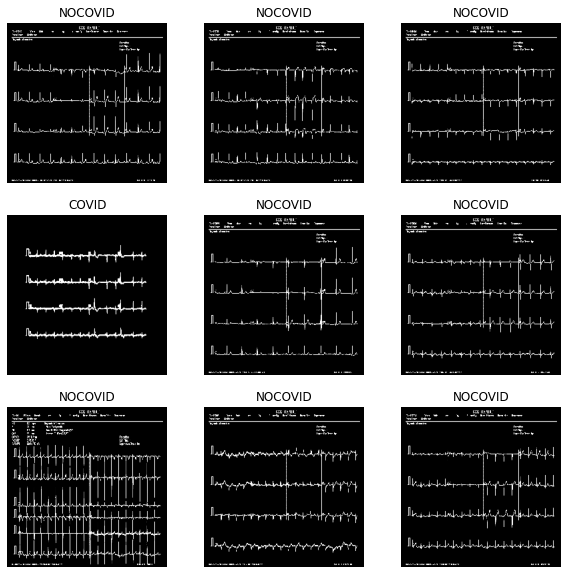

In [208]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"),cmap='gray', vmin=0, vmax=255)
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Configure the dataset for performance

In [209]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data augmentation

In [191]:
data_augmentation = keras.Sequential(
  [
  
    layers.experimental.preprocessing.RandomRotation(0.1,input_shape=(img_height, 
                                                              img_width,
                                                              1)),
      layers.experimental.preprocessing.RandomHeight((0,0.2), interpolation='bilinear',input_shape=(img_height, 
                                                              img_width,
                                                              1)),
      layers.experimental.preprocessing.RandomWidth((0,0.2), interpolation='bilinear',input_shape=(img_height, 
                                                              img_width,
                                                              1)),
      layers.experimental.preprocessing.Resizing(img_height,img_width),
      

  ]
)

### Data augmentation visulization

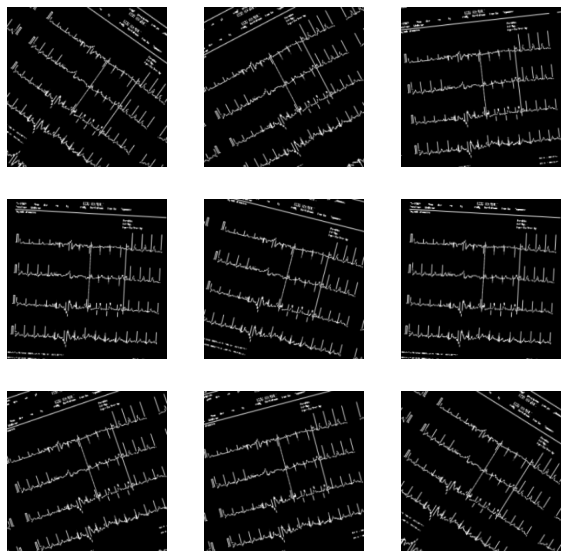

In [210]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"),cmap='gray', vmin=0, vmax=255)
    plt.axis("off")

### Model

In [211]:
num_classes = 2

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(3),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [212]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [213]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_14 (Sequential)   (None, 240, 240, 1)       0         
_________________________________________________________________
rescaling_8 (Rescaling)      (None, 240, 240, 1)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 240, 240, 16)      416       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 40, 40, 64)      

In [214]:
epochs= 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
49/49 [==============================] - 7s 134ms/step - loss: 0.1387 - accuracy: 0.9444 - val_loss: 0.0657 - val_accuracy: 0.9948
Epoch 2/15
49/49 [==============================] - 6s 114ms/step - loss: 0.0448 - accuracy: 0.9935 - val_loss: 0.0693 - val_accuracy: 0.9948
Epoch 3/15
49/49 [==============================] - 6s 114ms/step - loss: 0.0483 - accuracy: 0.9935 - val_loss: 0.0518 - val_accuracy: 0.9948
Epoch 4/15
49/49 [==============================] - 6s 114ms/step - loss: 0.0454 - accuracy: 0.9929 - val_loss: 0.0724 - val_accuracy: 0.9948
Epoch 5/15
49/49 [==============================] - 6s 114ms/step - loss: 0.0514 - accuracy: 0.9922 - val_loss: 0.0839 - val_accuracy: 0.9948
Epoch 6/15
49/49 [==============================] - 6s 114ms/step - loss: 0.0514 - accuracy: 0.9935 - val_loss: 0.0480 - val_accuracy: 0.9948
Epoch 7/15
49/49 [==============================] - 6s 114ms/step - loss: 0.0433 - accuracy: 0.9935 - val_loss: 0.0471 - val_accuracy: 0.9948
Epoch 

### performance visualization

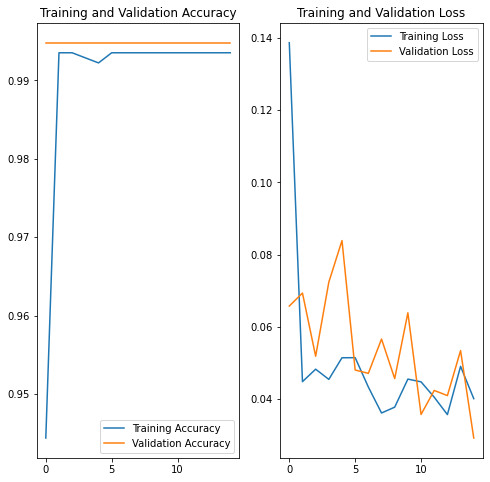

In [215]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()